### IMPORTS

In [1]:
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
def gaussian_entropy(sigma):
    return 0.5 * q.sigma.shape[0] * (1.0 + torch.log(2*torch.tensor(np.pi))) + torch.sum(torch.log(sigma))

In [5]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [7]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

In [31]:
model = nn.Sequential( nn.Linear(1, 20),
                       nn.SELU(), 
                       nn.Linear(20, 1),
                     ).to(device)

In [32]:
param_count = get_param(model).shape[0]

In [34]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [35]:
def logprior(x):
    return prior.log_prob(x)

In [36]:
def loglikelihood(theta, model, x, y, sigma_noise):
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [37]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [38]:
q = MeanFieldVariationalDistribution(param_count, sigma=0.01, device=device)
q.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 

q.rho.requires_grad = True
q.mu.requires_grad = True

In [39]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [40]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

In [41]:
flip_parameters_to_tensors(model)

In [48]:
n_samples_ELBO = 100

In [49]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

In [50]:
q.mu.detach_().requires_grad_(True)
q.rho.detach_().requires_grad_(True);

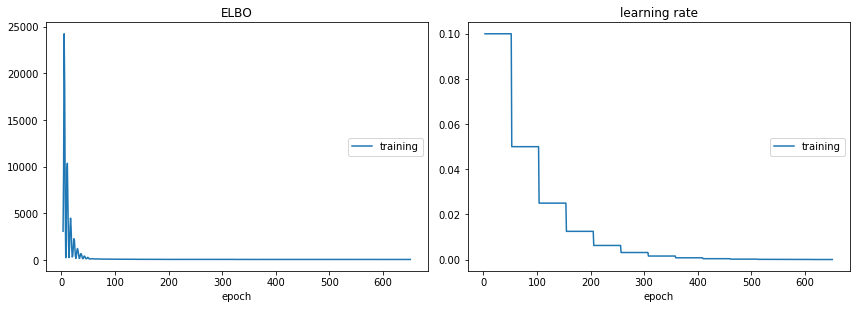

ELBO:
training   (min:   54.638, max: 47435.359, cur:   68.707)

learning rate:
training   (min:    0.000, max:    0.100, cur:    0.000)


KeyboardInterrupt: 

In [51]:
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    listDIV = []
    for i in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        listDIV.append((LQ - LP))

    L = torch.stack(listDIV).mean()

    #with torch.no_grad():
    #    LL = predictive_loglikelihood(z).mean().detach().clone()

    L.backward()

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()

    if learning_rate < 0.00001:
        break

In [52]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

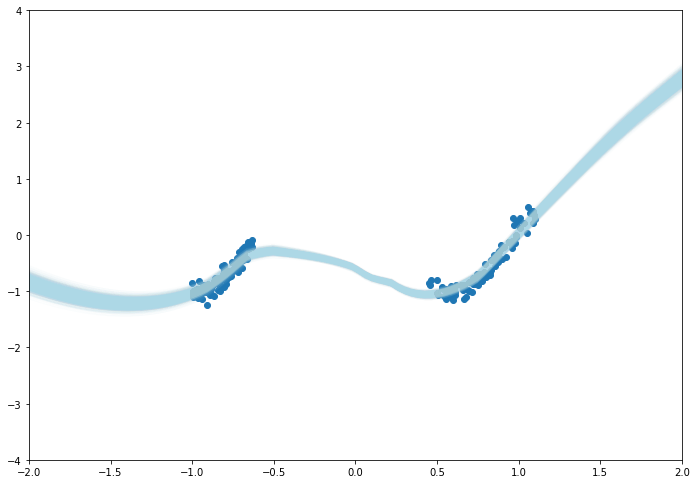

In [53]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = q.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

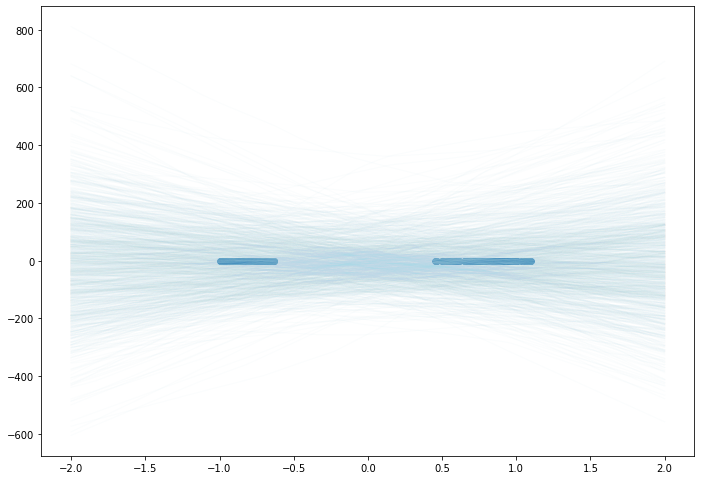

In [24]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = prior.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')